<a href="https://colab.research.google.com/github/yoineko/skillfactory-module6/blob/master/fite_tuning_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Это пример решения задачи с использованием модели EfficientNetB0. 
# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть EfficientNetB0 и применить Transfer learning & fine-tuning. 


In [108]:
from google.colab import drive
drive.mount('/content/drive')
DIR = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
!nvidia-smi

Mon Aug 24 14:25:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |   2603MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
from pathlib import Path


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB6, EfficientNetB7, EfficientNetB0
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K


from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir(DIR + "input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sample-submission.csv', 'test.zip', 'train.csv', 'train.zip', 'train.gsheet', 'sample-submission.gsheet']
Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [111]:
!pip freeze > requirements.txt

# Основные настройки

In [112]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 32
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче

IMG_SIZE             = 224 # какого размера подаем изображения в сеть (# input shape expected resolution )
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

PATH = "../working/car/" # рабочая директория


DATA_PATH = DIR + 'input/'
ver = '61_1'

In [113]:
# Устаналиваем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [114]:
train_df = pd.read_csv(os.path.join(DATA_PATH,"train.csv"))
sample_submission = pd.read_csv(os.path.join(DATA_PATH,"sample-submission.csv"))

In [117]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DIR + "/input/"+data_zip,"r") as z:    
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


# Подготовка данных

### Аугментация данных

In [ ]:
# Так как у нас небольшой датасет, то применем к нему аугментацию  данных.
train_datagen = ImageDataGenerator(
   # rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
    )

test_datagen = ImageDataGenerator(
  #  rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
    )

### Генерация данных

In [ ]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = train_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


In [123]:
# чистит сессию в Keras и TF
def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
    tf.compat.v1.keras.backend.set_session(s)

s = reset_tf_session()

# Построение модели

### Загружаем предобученную сеть EfficientNetB0:

In [140]:
# Загружаем базовую модель, добавляем параметр drop_connect_rate=0.4, чтобы избежать сильного переобучения после первого этапа обучения
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape = input_shape, drop_connect_rate=0.4)

In [150]:
# Устанавливаем новую "голову" (head)
base_model.training=False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(100, activation='relu')(x)
x= Dropout(0.2)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

И EarlyStopping, чтобы не терять время на обучении, если нет улучшения в течение заданного количества эпох.

In [133]:
checkpoint = ModelCheckpoint(os.path.join(DIR, f'best_model/best_model{ver}.hdf5') , monitor = 'val_accuracy' , verbose = 1  , save_best_only = True, mode = 'max')
earlystop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]


In [124]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()

In [154]:
# mode_train = False - замораживаем все слои, True - модель частично или полностью тренируемая
def config_model(mode_train, l_r, ephochs,  fine_tune_at = 0):

    base_model.trainable = mode_train

    if fine_tune_at > 0 :
# Замораживаем все первые перед fine_tune_at слоев
      for layer in model.layers[:fine_tune_at]:
            layer.trainable =  False

# Слои BatchNormalization никогда не тренируем
    for layer in model.layers[fine_tune_at:]:
        if  isinstance(layer, BatchNormalization):
            layer.trainable  =  False  

# фиксируем настройку
    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=l_r), metrics=["accuracy"])

# маленькая проверка перед обучением
    scores = model.evaluate(test_generator, steps=1, verbose=1)
    print("Accuracy before fit: %.2f%%" % (scores[1]*100))

#обучаем 
    history =    model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = ephochs,
        callbacks = callbacks_list
       )
    
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
    model.save(os.path.join(DIR, f'working/model_last{ver}.hdf5'))

    model.load_weights(os.path.join(DIR, f'best_model/best_model{ver}.hdf5'))

# тестируем
    scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
    print("Accuracy after: %.2f%%" % (scores[1]*100))

#Анализируем поведение  
    plot_history(history)

# Fine-tuning 

In [ ]:
# Смотрим структуру базовой сети , определяем границы блоков, чтобы в дальнейшем размораживать по границам блоков
base_model.summary()

1/1 [==============================] - 0s 2ms/step - loss: 2.3929 - accuracy: 0.0000e+00
Accuracy before fit: 0.00%
Epoch 1/5
414/414 [==============================] - ETA: 0s - loss: 1.7968 - accuracy: 0.3511
Epoch 00001: val_accuracy did not improve from 0.69987
414/414 [==============================] - 232s 561ms/step - loss: 1.7968 - accuracy: 0.3511 - val_loss: 1.3137 - val_accuracy: 0.5041
Epoch 2/5
414/414 [==============================] - ETA: 0s - loss: 1.3240 - accuracy: 0.5159
Epoch 00002: val_accuracy did not improve from 0.69987
414/414 [==============================] - 232s 561ms/step - loss: 1.3240 - accuracy: 0.5159 - val_loss: 1.0380 - val_accuracy: 0.6329
Epoch 3/5
414/414 [==============================] - ETA: 0s - loss: 1.1470 - accuracy: 0.5828
Epoch 00003: val_accuracy did not improve from 0.69987
414/414 [==============================] - 232s 560ms/step - loss: 1.1470 - accuracy: 0.5828 - val_loss: 1.0040 - val_accuracy: 0.6286
Epoch 4/5
414/414 [==========

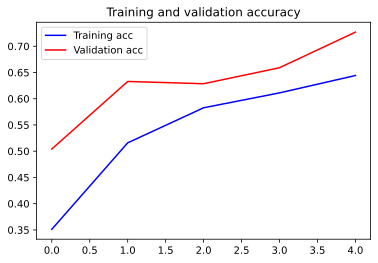

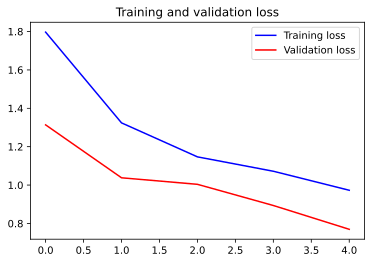

1/1 [==============================] - 0s 2ms/step - loss: 0.9414 - accuracy: 0.6875
Accuracy before fit: 68.75%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 0.8416 - accuracy: 0.6955
Epoch 00001: val_accuracy did not improve from 0.72692
414/414 [==============================] - 234s 565ms/step - loss: 0.8416 - accuracy: 0.6955 - val_loss: 0.7624 - val_accuracy: 0.7179
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.7867
Epoch 00002: val_accuracy improved from 0.72692 to 0.82611, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model61_1.hdf5
414/414 [==============================] - 235s 566ms/step - loss: 0.5862 - accuracy: 0.7867 - val_loss: 0.4839 - val_accuracy: 0.8261
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 0.4681 - accuracy: 0.8255
Epoch 00003: val_accuracy improved from 0.82611 to 0.82782, saving model to /content/drive/My Drive/Colab

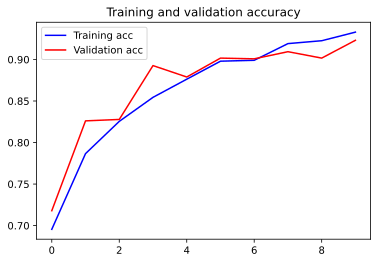

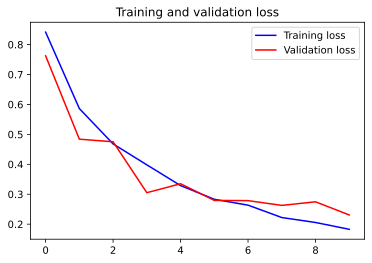

1/1 [==============================] - 0s 2ms/step - loss: 0.3169 - accuracy: 0.9062
Accuracy before fit: 90.62%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.9512
Epoch 00001: val_accuracy improved from 0.92314 to 0.92658, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model61_1.hdf5
414/414 [==============================] - 235s 569ms/step - loss: 0.1291 - accuracy: 0.9512 - val_loss: 0.2087 - val_accuracy: 0.9266
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9540
Epoch 00002: val_accuracy improved from 0.92658 to 0.93388, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model61_1.hdf5
414/414 [==============================] - 234s 566ms/step - loss: 0.1224 - accuracy: 0.9540 - val_loss: 0.2083 - val_accuracy: 0.9339
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 0.1189 - accuracy

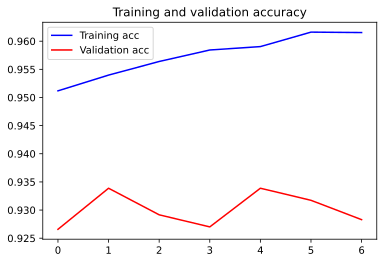

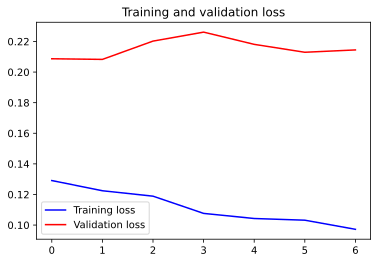

1/1 [==============================] - 0s 2ms/step - loss: 0.4796 - accuracy: 0.9062
Accuracy before fit: 90.62%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 2.7429 - accuracy: 0.1875
Epoch 00001: val_accuracy did not improve from 0.93388
414/414 [==============================] - 236s 569ms/step - loss: 2.7429 - accuracy: 0.1875 - val_loss: 0.4021 - val_accuracy: 0.8751
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 2.4014 - accuracy: 0.2113

KeyboardInterrupt: ignored

In [151]:
base_layers = len(base_model.layers)
# step 1 Обучаем только голову
config_model(False, l_r = 1e-3, ephochs = 5,   fine_tune_at = 0)

# step 2 Обучаем последний блок базовой модели
config_model(True, l_r = 1e-4, ephochs = 10,  fine_tune_at = 162) 

# step 3 Обучаем три последних блока базовой модели
config_model(True, l_r = 1e-5, ephochs = 10,  fine_tune_at = 75) 

#config_model(True, l_r = 1e-5, ephochs = 10,  fine_tune_at = 46)  
#config_model(True, l_r = 6e-6, ephochs = 10 ,  fine_tune_at = 0)

Обучение на первом шаге приносит неплохой результат 71%

Обучение на втором шаге: переобучения нет! Точность уже 92,53% 

Обучение на третьем шаге почти не дает улучшения , точность всего 92,96%



73/73 [==============================] - 35s 476ms/step - loss: 0.2171 - accuracy: 0.9257
Accuracy before fit: 92.57%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9606
Epoch 00001: val_accuracy did not improve from 0.93388
414/414 [==============================] - 235s 568ms/step - loss: 0.1084 - accuracy: 0.9606 - val_loss: 0.2347 - val_accuracy: 0.9249
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9596
Epoch 00002: val_accuracy did not improve from 0.93388
414/414 [==============================] - 234s 565ms/step - loss: 0.1079 - accuracy: 0.9596 - val_loss: 0.2252 - val_accuracy: 0.9261
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9619
Epoch 00003: val_accuracy improved from 0.93388 to 0.93602, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model61_1.hdf5
414/414 [==============================] - 23

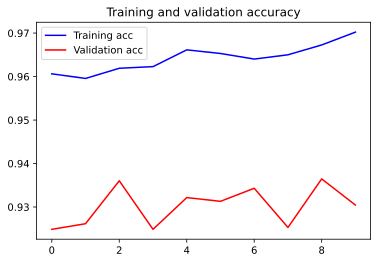

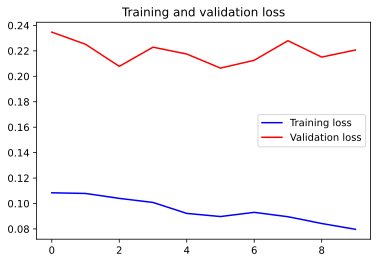

1/1 [==============================] - 0s 2ms/step - loss: 0.7493 - accuracy: 0.9062
Accuracy before fit: 90.62%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9684
Epoch 00001: val_accuracy did not improve from 0.93645
414/414 [==============================] - 235s 567ms/step - loss: 0.0812 - accuracy: 0.9684 - val_loss: 0.2181 - val_accuracy: 0.9360
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9686
Epoch 00002: val_accuracy did not improve from 0.93645
414/414 [==============================] - 234s 565ms/step - loss: 0.0803 - accuracy: 0.9686 - val_loss: 0.2138 - val_accuracy: 0.9356
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9698
Epoch 00003: val_accuracy did not improve from 0.93645
414/414 [==============================] - 235s 568ms/step - loss: 0.0792 - accuracy: 0.9698 - val_loss: 0.2088 - val_accuracy: 0.9339
Epoch 4/10
414/414 [=========

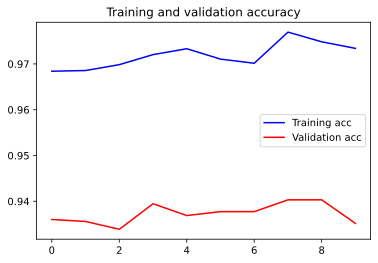

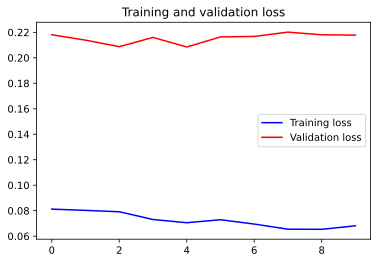

In [155]:
model.load_weights(os.path.join(DIR, f'best_model/best_model{ver}.hdf5'))
# step 4 Добавляем на обучение еще один блок
config_model(True, l_r = 1e-5, ephochs = 10,  fine_tune_at = 46) 
# step 5 Обучаем всю модель
config_model(True, l_r = 6e-6, ephochs = 10 ,  fine_tune_at = 0)

Обучение на четвертом шаге медленно , но верно улучшает точность и дает 93,39%. Возможно, стоит взять большее число эпох.

Заключительный шаг  - точность растет , но медленно. Конечный на ваидации результат всего 93.73%. Можно попробовать увеличить число эпох. 

На текущий момент результат хуже , чем fine-tuning с xception(около 96 %)

Около 150 неверно предсказанных моделей. Чаще всего идет ошибка в предсказаниях между 7 и 9 категорией машин ( 9-ая модель и 99-ая модель), которые действительно очень похожи. Так же встречаются ошибки в тренировочном наборе данных.

# Предсказание на тестовых данных

In [ ]:
test_sub_generator.samples

In [ ]:
from tqdm import tqdm

test_sub_generator.reset()
tta_steps = 10
l_predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    l_predictions.append(preds)

pred = np.mean(l_predictions, axis=0)


predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(DIR + f'submission/submission_{ver}.csv', index=False)
print('Save submit')


In [ ]:
submission.head()